# Importing libraries & Dataset

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


In [4]:
test_data=pd.read_csv('/content/test.csv')
train_data=pd.read_csv('/content/train.csv')
training_extra_data=pd.read_csv('/content/training_extra.csv')
submission = pd.read_csv('/content/sample_submission.csv')


In [5]:
combined_train = pd.concat([train_data, training_extra_data], ignore_index=True)
print("Combined training shape:", combined_train.shape)

Combined training shape: (3994318, 11)


In [6]:
combined_train.head(10)

,id,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg),Price
0,0,Jansport,Leather,Medium,7.0,Yes,No,Tote,Black,11.611723,112.15875
1,1,Jansport,Canvas,Small,10.0,Yes,Yes,Messenger,Green,27.078537,68.88056
2,2,Under Armour,Leather,Small,2.0,Yes,No,Messenger,Red,16.643760,39.17320
3,3,Nike,Nylon,Small,8.0,Yes,No,Messenger,Green,12.937220,80.60793
4,4,Adidas,Canvas,Medium,1.0,Yes,Yes,Messenger,Green,17.749338,86.02312
5,5,Nike,Canvas,Medium,10.0,No,Yes,NaN,Black,7.241812,20.01553
6,6,Nike,NaN,Large,3.0,No,No,Backpack,Green,6.828123,84.80500
7,7,Puma,Canvas,Small,1.0,Yes,Yes,Backpack,Blue,21.488864,27.15815
8,8,Under Armour,Polyester,Medium,8.0,Yes,No,Tote,Gray,10.207780,25.98652
9,9,Under Armour,Nylon,Medium,2.0,Yes,Yes,Messenger,Pink,15.895100,38.48741


In [7]:
combined_train.tail(10)

,id,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg),Price
3994308,4194308,Adidas,NaN,Large,5.0,Yes,Yes,Messenger,Gray,12.370109,18.99152
3994309,4194309,Adidas,Leather,Medium,9.0,No,Yes,Backpack,Blue,12.790800,103.92080
3994310,4194310,Adidas,Nylon,Small,10.0,No,NaN,Tote,Red,22.959725,128.51754
3994311,4194311,Puma,Polyester,Medium,4.0,Yes,Yes,Messenger,Pink,28.425845,107.18468
3994312,4194312,Jansport,Polyester,Large,6.0,Yes,Yes,Backpack,Red,16.641739,31.52978
3994313,4194313,Nike,Canvas,NaN,3.0,Yes,Yes,Messenger,Blue,28.098120,104.74460
3994314,4194314,Puma,Leather,Small,10.0,Yes,Yes,Tote,Blue,17.379531,122.39043
3994315,4194315,Jansport,Canvas,Large,10.0,No,No,Backpack,Red,17.037708,148.18470
3994316,4194316,Puma,Canvas,NaN,2.0,No,No,Backpack,Gray,28.783339,22.32269
3994317,4194317,Under Armour,Polyester,Medium,2.0,Yes,No,Backpack,Blue,23.076169,107.61199


In [8]:
combined_train.isnull().sum()

,0
id,0
Brand,126758
Material,110962
Size,87785
Compartments,0
Laptop Compartment,98533
Waterproof,94324
Style,104180
Color,133617
Weight Capacity (kg),1808


In [9]:
combined_train.duplicated().sum()

0

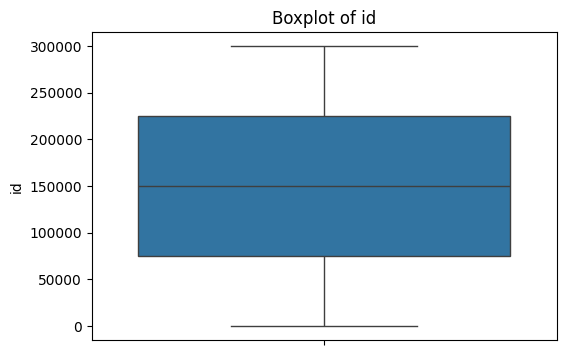

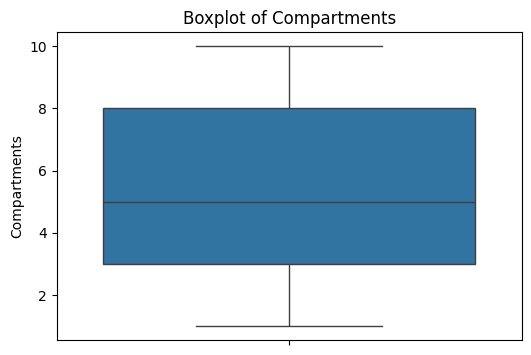

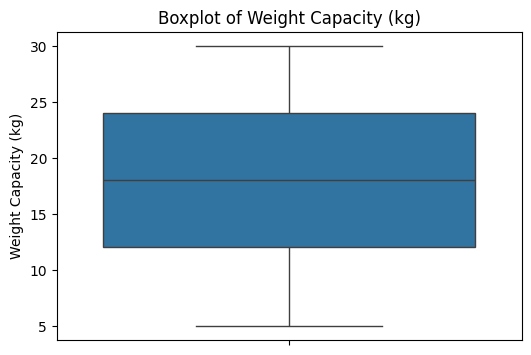

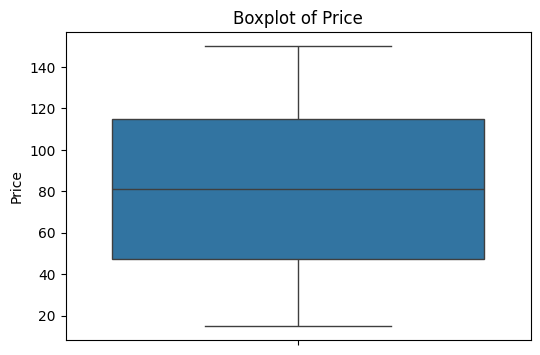

In [10]:
numeric_cols = combined_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
for col in numeric_cols:
    plt.figure(figsize=(6,4))
    sns.boxplot(y=train_data[col])
    plt.title(f'Boxplot of {col}')
    plt.show()

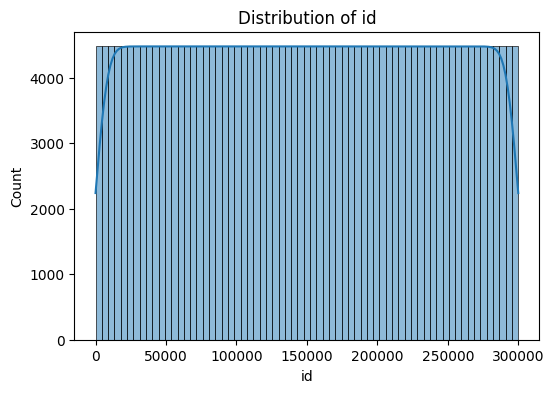

Skewness of id: 0.0


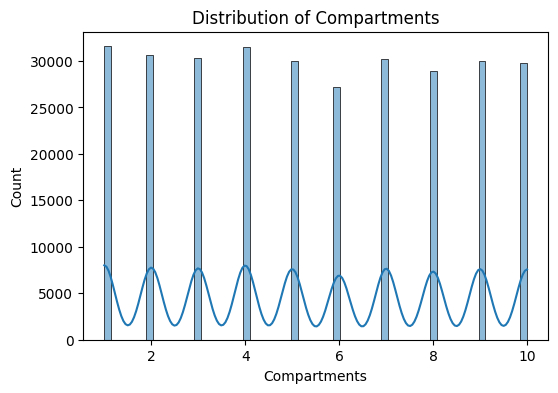

Skewness of Compartments: 0.029124529079775485


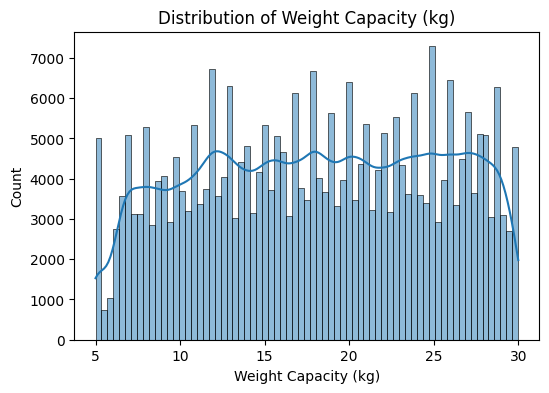

Skewness of Weight Capacity (kg): -0.06423900616005432


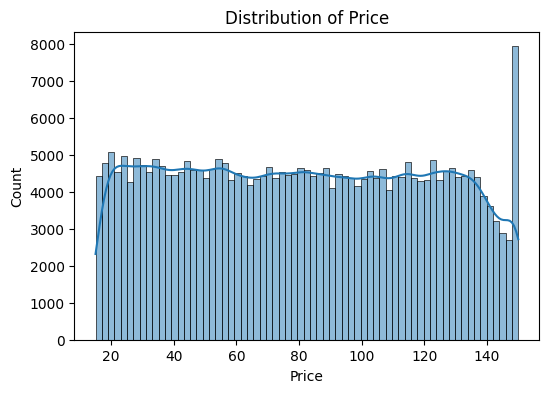

Skewness of Price: 0.036882755131099065


In [11]:
numeric_cols = combined_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
for col in numeric_cols:
    plt.figure(figsize=(6, 4))
    sns.histplot(train_data[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.show()
    print(f"Skewness of {col}: {train_data[col].skew()}")


In [12]:
X = combined_train.drop("Price", axis=1)
y = combined_train["Price"]

In [13]:
cat_features = ["Brand", "Material", "Size", "Laptop Compartment", "Waterproof", "Style", "Color"]

In [14]:
for col in cat_features:
    if col in X.columns:
        X[col] = X[col].astype(str)
    if col in test_data.columns:
        test_data[col] = test_data[col].astype(str)

In [15]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
train_pool = Pool(X_train, y_train, cat_features=cat_features)
val_pool = Pool(X_val, y_val, cat_features=cat_features)

In [19]:
model = CatBoostRegressor(
    iterations=1500,           # Enough iterations to capture complex patterns in a large dataset
    learning_rate=0.02,        # A low learning rate for stable, gradual learning
    depth=6,                   # Moderate depth to balance model complexity and overfitting risk
    l2_leaf_reg=10,            # Regularization to help control overfitting
    bagging_temperature=1,     # Introduces randomness for better generalization
    loss_function='RMSE',
    random_seed=42,
    task_type='GPU',           # Enable GPU acceleration
    devices='0',               # Use GPU device 0
    verbose=100
)


In [20]:
model.fit(train_pool, eval_set=val_pool, early_stopping_rounds=50)

0:	learn: 38.9433324	test: 38.9146056	best: 38.9146056 (0)	total: 350ms	remaining: 8m 44s
100:	learn: 38.9052825	test: 38.8780114	best: 38.8780114 (100)	total: 35.9s	remaining: 8m 16s
200:	learn: 38.8951335	test: 38.8690775	best: 38.8690775 (200)	total: 1m 10s	remaining: 7m 32s
300:	learn: 38.8901506	test: 38.8650972	best: 38.8650972 (300)	total: 1m 44s	remaining: 6m 54s
400:	learn: 38.8870234	test: 38.8628689	best: 38.8628689 (400)	total: 2m 17s	remaining: 6m 17s
500:	learn: 38.8847077	test: 38.8614176	best: 38.8614176 (500)	total: 2m 51s	remaining: 5m 42s
600:	learn: 38.8828184	test: 38.8602631	best: 38.8602631 (600)	total: 3m 25s	remaining: 5m 8s
700:	learn: 38.8808383	test: 38.8590921	best: 38.8590921 (700)	total: 4m	remaining: 4m 33s
800:	learn: 38.8792723	test: 38.8583479	best: 38.8583417 (791)	total: 4m 34s	remaining: 3m 59s
900:	learn: 38.8775537	test: 38.8575252	best: 38.8575108 (894)	total: 5m 8s	remaining: 3m 25s
1000:	learn: 38.8760123	test: 38.8568923	best: 38.8568902 (999

In [26]:
val_pred = model.predict(X_val)
# Calculate MSE then take the square root for RMSE
mse = mean_squared_error(y_val, val_pred)
rmse = np.sqrt(mse)
print("Validation RMSE:", rmse)

Validation RMSE: 38.85518730035309


In [27]:
avg_price = train_data["Price"].mean()
print("Average Price:", avg_price)


Average Price: 81.41110683033334


In [28]:
test_pred = model.predict(test_data)

In [30]:
submission["Price"] = test_pred
submission.to_csv('/content/Backpack Prediction Challenge_submission.csv', index=False)